## Multiples Testproblem
----------------------------------------

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from random import sample
from scipy.stats import f
from scipy import stats
import scipy.stats
import statsmodels.api as smi

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%run ../src/notebook_env.py


---------------------------------
Working on the host: LAPTOP-9LETB4SJ

---------------------------------
Python version: 3.10.2 | packaged by conda-forge | (main, Mar  8 2022, 15:52:24) [MSC v.1929 64 bit (AMD64)]

---------------------------------
Python interpreter: C:\Users\zak\anaconda3\envs\srh\python.exe


Eine Einschränkung der ANOVA besteht darin, dass wir, wenn wir die Nullhypothese ablehnen, feststellen, dass die Mittelwerte der betrachteten Populationen nicht alle gleich sind. Wir können jedoch weder entscheiden, welche Mittelwerte unterschiedlich sind, noch, in welchem Verhältnis die Mittelwerte zueinander stehen.

Um diese Frage zu klären, wenden wir Methoden an, die als **multiples Testen** oder **Mehrfachvergleiche** bezeichnet werden. Das Problem bei Mehrfachvergleichen ist, dass je mehr Hypothesen für einen bestimmten Datensatz getestet werden, desto wahrscheinlicher ist es, dass die Nullhypothese fälschlicherweise zurückgewiesen wird. Daher erfordern die Methoden des Mehrfachvergleichs eine höhere Signifikanzschwelle ($\alpha$) für einzelne Vergleiche, um die Anzahl der gezogenen Schlüsse zu kompensieren.

### Family Wise Error Rate (FWER)

Eine **Testfamilie** ist der Fachbegriff für eine Reihe von Tests, die an einem Datensatz durchgeführt werden. Die <a href="https://de.wikipedia.org/wiki/Alphafehler-Kumulierung">Alphafehler-Kumulierung</a> (engl. Family Wise Error Rate) ist die Wahrscheinlichkeit, dass bei der Durchführung von Mehrfachhypothesentests ein oder mehrere falsche Zurückweisungen der Null-Hypothese oder Fehler vom <a href="https://de.wikipedia.org/wiki/Fehler_1._und_2._Art">Typ I</a> gemacht werden.

Es sei daran erinnert, dass bei einem Signifikanzniveau von $\alpha=0,05$ die Wahrscheinlichkeit, einen Fehler vom Typ I zu machen, $0,05$ oder $5 \%$ beträgt. Folglich ist die Wahrscheinlichkeit, keinen Fehler vom Typ I zu machen, $1-\alpha=1-0,05=0,95$. Außerdem ist die Wahrscheinlichkeit, zwei unabhängige Ereignisse zu beobachten, das Produkt ihrer Wahrscheinlichkeiten. Wenn wir also zwei unabhängige Tests durchführen, ist die Wahrscheinlichkeit, beim ersten und beim zweiten Test keinen Fehler vom Typ I zu machen

$$(1-\alpha) \times (1-\alpha) = (1-\alpha)^2$$

Wenn $\alpha=0,05$ ist, ergibt sich eine Wahrscheinlichkeit, dass beim ersten und zweiten Test kein Fehler vom Typ I auftritt, von

$$(1 - \alpha)^2 = (1-0,05)^2 = 0,95^2 \approx 0,902$$

Für eine Familie von $C$-Tests ist die Wahrscheinlichkeit, dass kein Fehler vom Typ I für die gesamte Familie auftritt, formal ausgedrückt

$$(1-\alpha)^C\text{.}$$

Betrachten wir nun $C=10$ und $\alpha=0,05$. Wir führen also $10$ Mehrfachvergleiche mit einem Datensatz durch. Die Wahrscheinlichkeit, keinen Fehler vom Typ I in der Familie zu machen, ist dann

$$(1-\alpha)^C=(1-0,05)^{10} \approx 0,599$$

Folglich ist die Wahrscheinlichkeit, dass **ein oder mehrere Fehler vom Typ I** in der Testfamilie auftreten

$$1 - (1-\alpha)^C$$

Für unser Beispiel finden wir

$$1 - (1-\alpha)^C = 1 - (1-0,05)^{10} \approx 0,401$$

Somit ist bei $\alpha=0,05$ für jeden der $10$ Mehrfachvergleiche die Wahrscheinlichkeit, dass die Nullhypothese falsch zurückgewiesen wird, $0,401$ oder $40,1 \%$.

Um diesem Problem Rechnung zu tragen, gibt es <a href="https://de.wikipedia.org/wiki/Alphafehler-Kumulierung">mehrere statistische Methoden</a>. In diesem Abschnitt werden die <a href="https://de.wikipedia.org/wiki/Bonferroni-Korrektur">Bonferroni-Korrektur</a> und die <a href="https://de.wikipedia.org/wiki/Post-hoc-Test#Tukey-Test">Tukey-Test</a>, auch bekannt als **Tukeys HSD-Test (hoenstly significant difference)**, behandelt.

### Beispiel-Daten

In diesem Abschnitt wiederholen wir das Beispiel aus dem vorherigen Abschnitt. Dort haben wir eine einfaktorielle ANOVA angewandt, um zu **testen, ob sich das mittlere Jahresgehalt der Absolventen zwischen den Absolventen verschiedener Studienfächer unterscheidet**. Dieses Mal werden wir jedoch mehrere Vergleiche durchführen, um die Beziehung zwischen allen Gruppenmittelwerten zu analysieren.

Laden Sie den `students` Datensatz erneut (Sie können die Datei `students.csv` <a href="https://userpage.fu-berlin.de/soga/200/2010_data_sets/students.csv">hier</a> herunterladen).

In [11]:
# Lese Datei students.csv als Dataframe ein; Indexspalte wird übersprungen
students = pd.read_csv('students.csv', index_col=0)

Der `students` Datensatz besteht aus $8239$ Zeilen, von denen jede einen bestimmten Studenten repräsentiert, und $16$ Spalten, von denen jede einer Variable/einem Merkmal entspricht, das sich auf diesen bestimmten Studenten bezieht. Diese selbsterklärenden Variablen sind: *stud.id, name, gender, age, height, weight, religion, nc.score, semester, major, minor, score1, score2, online.tutorial, graduated, salary.*

Aus dem Datensatz der Studierenden ziehen wir eine Zufallsstichprobe von $275$ Absolventen und reduzieren den Datensatz auf die beiden interessierenden Variablen, die kategoriale Variable `major` und die numerische Variable `salary`. Für eine bessere Lesbarkeit in der folgenden Analyse ersetzen wir die Namen der Studienfächer durch entsprechende Abkürzungen.

In [12]:
n=275
graduated = students.loc[students['graduated'] == 1]
data = pd.DataFrame(graduated['major'].sample(n,random_state=300))
data['salary']=graduated['salary']

data = data.replace('Biology', 'Bio')
data = data.replace('Political Science','PoS')
data = data.replace('Economics and Finance','EcFi')
data = data.replace('Environmental Sciences','EnS')
data = data.replace('Mathematics and Statistics','MaSt')
data = data.replace('Social Sciences','SoS')

data.head(10)

,major,salary
3826,MaSt,57849.343490
795,MaSt,56558.160738
2127,PoS,46945.174104
1292,Bio,40093.455971
5913,EnS,35106.961865
1871,EnS,33216.118981
1853,EnS,30606.198317
1484,PoS,37240.113342
5619,MaSt,50913.038493
2299,EcFi,50365.098269


Des Weiteren führen wir einen einfaktoriellen ANOVA-Hypothesentest in Python durch, indem wir die Funktion`f_oneway()` anwenden.

In [13]:
#statistics, pvalue = 
statistics,pvalue = stats.f_oneway(data['salary'][data['major'] == 'Bio'],
               data['salary'][data['major'] == 'SoS'],
               data['salary'][data['major'] == 'EcFi'],
               data['salary'][data['major'] == 'PoS'],
               data['salary'][data['major'] == 'MaSt'],
               data['salary'][data['major'] == 'EnS'])

print('Wert der F-Statistik :',statistics)
print('p-Wert :',pvalue)

Wert der F-Statistik : 41.14261241723519
p-Wert : 2.2838978944953763e-31


### Bonferroni-Korrektur

Die Bonferroni-Korrektur kompensiert die erhöhte Wahrscheinlichkeit, dass eine Nullhypothese aufgrund von Mehrfachvergleichen fälschlicherweise abgelehnt wird (Fehler vom Typ I), indem das Signifikanzniveau $\alpha$ in folgender Form angepasst wird

$$\alpha = \frac{\alpha}{m}\text{,}$$

wobei $m$ der Anzahl der Vergleiche entspricht, die gegeben ist durch

$$m=\frac{k(k-1)}{2}\text{,}$$

wobei $k$ den Ebenen des Faktors entspricht, der die kategoriale Klassifikationsvariable ist.

In [14]:
m = 6*(6-1)/2
alpha_bonf = 0.1/m
alpha_bonf

0.006666666666666667

### Der paarweiser $t$-Test in Python: Bonferroni-Korrektur

Wie im vorigen Abschnitt erwähnt, ist eine einseitige Varianzanalyse die Verallgemeinerung des gepoolten $t$-Tests auf mehr als zwei Grundgesamtheiten. Die Python-Funktion zur Durchführung von Mehrfachvergleichen ist `ttest_ind()`. Die Funktion `ttest_ind()` vergleicht die jeweiligen Gehaltsverteilungen (`salary`) nach Studienfächer gruppiert (`major`) miteinander.

Zunächst führen wir einen paarweisen $t$-Test ohne Anpassung durch, wodurch sich die Wahrscheinlichkeit erhöht, dass die Nullhypothese falsch zurückgewiesen wird.

In [15]:
major= [['Bio','EcFi'],['Bio','EnS'],['Bio','MaSt'],['Bio','PoS'],['Bio','SoS'],['EcFi','EnS'],['EcFi','MaSt'],['EcFi','PoS'],['EcFi','SoS'],['EnS','MaSt'],['EnS','PoS'],['EnS','SoS'],['MaSt','PoS'],['MaSt','SoS'],['PoS','SoS']]

alpha = 0.05
data_groups = data.groupby('major').groups
#p_unc = []
for major1, major2 in major:
    print(major1,major2)
    print(stats.ttest_ind(data.loc[data_groups[major1]].salary,data.loc[data_groups[major2]].salary))
    
    statistics,p_value=stats.ttest_ind(data.loc[data_groups[major1]].salary,data.loc[data_groups[major2]].salary)
    print('**Reject:**', p_value <= alpha)

Bio EcFi
Ttest_indResult(statistic=0.6568547826087677, pvalue=0.5127682352930607)
**Reject:** False
Bio EnS
Ttest_indResult(statistic=8.848666376720532, pvalue=1.790220430001192e-14)
**Reject:** True
Bio MaSt
Ttest_indResult(statistic=1.1830026917324552, pvalue=0.23955813674375898)
**Reject:** False
Bio PoS
Ttest_indResult(statistic=9.183045185809336, pvalue=4.840684911699569e-15)
**Reject:** True
Bio SoS
Ttest_indResult(statistic=9.02308688531864, pvalue=6.474671293237731e-14)
**Reject:** True
EcFi EnS
Ttest_indResult(statistic=7.783093180767482, pvalue=8.151876693739742e-12)
**Reject:** True
EcFi MaSt
Ttest_indResult(statistic=0.5062070937193607, pvalue=0.6139629263411384)
**Reject:** False
EcFi PoS
Ttest_indResult(statistic=8.090807534529128, pvalue=2.649042688427034e-12)
**Reject:** True
EcFi SoS
Ttest_indResult(statistic=8.244260895704118, pvalue=7.1456783247184506e-12)
**Reject:** True
EnS MaSt
Ttest_indResult(statistic=-7.03158124781387, pvalue=2.8739133454494936e-10)
**Reject:*

Der paarweise $t$-Test zeigt, dass bei einem Signifikanzniveau von $5 \%$ die Mittelwerte für $5$ Kombinationen **nicht** statistisch signifikant unterschiedlich sind. Diese Kombinationen sind Bio-EcFi, Bio-MaSt, EcFi-MaSt, EnS-PoS, PoS-SoS mit $p$-Werten von $0,5128$, $0,2396$, $0,61396$ , $0,1202$ , $0,635057$ bzw. $0,230977$. Für die restlichen $9$ Kombinationen verwerfen wir $H_0$; d. h. für $10$ Kombinationen sind die Mittelwerte bei einem Signifikanzniveau von $5 \%$ unterschiedlich!

Zweitens führen wir einen **paarweisen $t$-Test mit der Bonferroni-Anpassung** durch. Wir verwenden die gleichen Daten wie für den paarweisen $t$-Test ohne Anpassung, geben setzen aber diesmal `alpha = alpha_bonf`.

In [16]:
for major1, major2 in major:
    print(major1,major2)
    print(stats.ttest_ind(data.loc[data_groups[major1]].salary,data.loc[data_groups[major2]].salary))
    
    statistics,p_value=stats.ttest_ind(data.loc[data_groups[major1]].salary,data.loc[data_groups[major2]].salary)
    print('**Reject:**', p_value <= alpha_bonf)

Bio EcFi
Ttest_indResult(statistic=0.6568547826087677, pvalue=0.5127682352930607)
**Reject:** False
Bio EnS
Ttest_indResult(statistic=8.848666376720532, pvalue=1.790220430001192e-14)
**Reject:** True
Bio MaSt
Ttest_indResult(statistic=1.1830026917324552, pvalue=0.23955813674375898)
**Reject:** False
Bio PoS
Ttest_indResult(statistic=9.183045185809336, pvalue=4.840684911699569e-15)
**Reject:** True
Bio SoS
Ttest_indResult(statistic=9.02308688531864, pvalue=6.474671293237731e-14)
**Reject:** True
EcFi EnS
Ttest_indResult(statistic=7.783093180767482, pvalue=8.151876693739742e-12)
**Reject:** True
EcFi MaSt
Ttest_indResult(statistic=0.5062070937193607, pvalue=0.6139629263411384)
**Reject:** False
EcFi PoS
Ttest_indResult(statistic=8.090807534529128, pvalue=2.649042688427034e-12)
**Reject:** True
EcFi SoS
Ttest_indResult(statistic=8.244260895704118, pvalue=7.1456783247184506e-12)
**Reject:** True
EnS MaSt
Ttest_indResult(statistic=-7.03158124781387, pvalue=2.8739133454494936e-10)
**Reject:*

Der paarweise $t$-Test mit der Bonferroni-Anpassung zeigt, dass bei einem Signifikanzniveau von $5 \%$ die Mittelwerte für $5$ Kombinationen nicht statistisch signifikant unterschiedlich sind. Bei diesen Kombinationen handelt es sich um Bio-EcFi, Bio-MaSt, EcFi-MaSt, EnS-PoS, PoS-SoS mit $p$-Werten von $0,5128$, $0,2396$, $0,61397$ , $0,1202$ bzw. $0,230978$. (beim Bonferroni-Verfahren wird $\alpha$ durch die Anzahl der Tests geteilt bzw. der $p$-Wert mit dieser Anzahl multipliziert und auf $1$ gekürzt, wenn das Ergebnis über $1$ liegt und somit keine Wahrscheinlichkeit darstellt). Für die verbleibenden $10$ Kombinationen haben wir $H_0$ abgelehnt, d. h. für $10$ Kombinationen sind die Mittelwerte bei einem Signifikanzniveau von $\approx 0,0067 \%$ unterschiedlich!

### Tukey-Mehrfach-Vergleichsmethode

Der <a href="https://de.wikipedia.org/wiki/Post-hoc-Test#Tukey-Test">Tukey-Test</a>, auch bekannt als **Tukey's HSD-Test (honest significant difference)**, basiert auf der <a href="http://www.uni-koeln.de/~a0032/statistik/texte/mult-comp.pdf">studentized range-Verteilung</a>, die manchmal auch als $q$-Verteilung bezeichnet wird. Die **$q$-Verteilung** ist eine rechtsschiefe Wahrscheinlichkeitsdichtekurve mit zwei Parametern, $\kappa$ und $\nu$, die ihre Form beschreiben. Diese Parameter sind gegeben durch

$$\kappa = k$$

und

$$\nu = n-k\text{,}$$

wobei $n$ die Gesamtzahl der Beobachtungen ist und $k$ die Anzahl der Gruppen/Klassen.

Der Tukey-Test vergleicht die Mittelwerte jeder Gruppe mit den Mittelwerten jeder anderen Gruppe. Er liefert das Konfidenzintervall für jede

$$\mu_i-\mu_j\text{.}$$

Wenn das Konfidenzintervall für einen paarweisen Vergleich $0$ einschließt, wird $H_0$ nicht verworfen, es wird nicht angenommen, dass sie signifikant unterschiedlich sind. Alle anderen Paare, für die das Konfidenzintervall nicht $0$ einschließt, sind signifikant unterschiedlich, $H_0$ wird also verworfen.

### Tukey's Test in Python

In Python werden Tukey's HSD Tests durch die `pairwise_tukeyhsd()` Funktion berechnet. Die `pairwise_tukeyhsd()`-Funktion erwartet als Eingabe `endog`, die zu vergleichende Größe und `groups` die Aufteilung der Gruppen. Um die Breite der Konfidenzintervalle festzulegen, geben wir der Funktion das Konfidenzniveau mit dem Argument `alpha` an.

In [17]:
# Tukey's test ausführen
tukey = pairwise_tukeyhsd(endog=data['salary'],
                          groups=data['major'],
                          alpha=0.05)
# Gebe Ergebniss aus
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Bio,EcFi,-1012.3086,0.983,-5228.585,3203.9678,False
Bio,EnS,-11777.6601,0.0,-15810.772,-7744.5482,True
Bio,MaSt,-1846.3679,0.8039,-6036.7581,2344.0223,False
Bio,PoS,-13913.133,0.0,-18078.5879,-9747.6782,True
Bio,SoS,-16091.4853,0.0,-21100.7005,-11082.2702,True
EcFi,EnS,-10765.3515,0.0,-15067.6403,-6463.0628,True
EcFi,MaSt,-834.0593,0.9946,-5284.1231,3616.0045,False
EcFi,PoS,-12900.8245,0.0,-17327.4159,-8474.233,True
EcFi,SoS,-15079.1768,0.0,-20307.5545,-9850.799,True
EnS,MaSt,9931.2922,0.0,5654.369,14208.2155,True


Bitte beachten Sie, dass wir im Fall ohne $p$-Wert-Anpassung die Nullhypothese für $10$ Kombinationen abgelehnt haben. Beim paarweisen $t$-Test mit der Tukey-Anpassung wurde die Nullhypothese für $9$ Kombinationen verworfen.

Die Tabelle zeigt die Differenz zwischen den einzelnen Paaren, die $95 \%$-Konfidenzintervalle und den $p$-Wert der paarweisen Vergleiche. Schauen Sie sich die Tabelle genau an, und Sie werden sehen, dass für alle $6$ Vergleiche, bei denen das Konfidenzintervall $0$ einschließt, der $p$-Wert höher ist als das Signifikanzniveau $\alpha$. Wenn $p \gt \alpha$ ist, verwerfen wir $H_0$ nicht, d. h. es gibt keinen statistisch signifikanten Unterschied zwischen den Mittelwerten dieser beiden Gruppen. Für alle Paare, bei denen $p \le \alpha$ ist, verwerfen wir dagegen $H_0$ und stellen fest, dass ein statistisch signifikanter Unterschied zwischen den Mittelwerten dieser Paare besteht. Die `tukey.plot_simultaneous()`-Funktion bietet eine nette Plot-Funktion, die die Konfidenzintervalle für jedes Paar visualisiert.

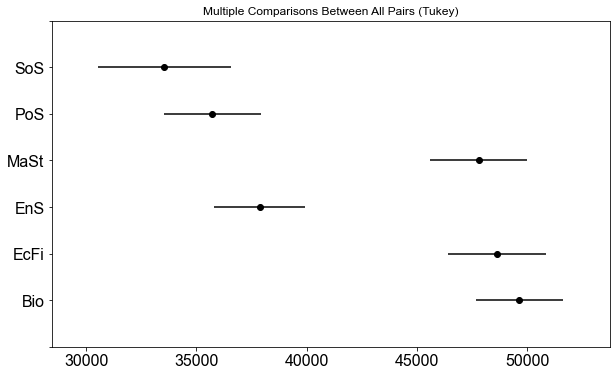

In [18]:
_=tukey.plot_simultaneous()